# This notebook aims at testing different robust models mentionned with Guillaume

## Load the data in pickle file 

In [1]:
# Load the data
import pickle
import numpy as np

with open('ssp585_time_series.pkl', 'rb') as f:
    dic_ssp585 = pickle.load(f)

In [2]:
import os 
import matplotlib.pyplot as plt

# Get the list of all files and directories
path = "/net/atmos/data/cmip6-ng/tos/ann/g025"
dir_list = os.listdir(path)

print("Files and directories in '", path, "' :")

list_model = []
list_forcing = []

for idx, file in enumerate(dir_list):

    file_split = file.split("_")
    
    # extract model names
    model_name = file_split[2]
    forcing = file_split[3]
    run_name = file_split[4]
    
    list_model.append(model_name)
    list_forcing.append(forcing)
    
model_names = list(set(list_model))
forcing_names = list(set(list_forcing))

Files and directories in ' /net/atmos/data/cmip6-ng/tos/ann/g025 ' :


# Preprocessing of the data: $(x_{i,t,m}^{p})_{i=1,\ldots,I, t=1,\ldots,T,m=1,\ldots,M, p=1,\ldots,d}$
## $i$: ensemble member (run) index
## $t$: time index
## $m$: model index
## $p$: grid cell index

#### Keep the model with at least 3 ensemble memebers and downscale the data from latitude 144 -> 36 with local averaging (to match with ensemble methods

In [3]:
# first filter out the models that do not contain ensemble members 
dic_reduced_ssp585 = {}

for m in list(dic_ssp585.keys()):
    if len(dic_ssp585[m].keys()) > 2:
        dic_reduced_ssp585[m] = dic_ssp585[m].copy()

### 1) Compute anomalies: $\displaystyle \overline{x}_{i,t,m}^p = x_{i,t,m}^p - \frac{1}{t_{\mathrm{ref}}^f - t_{\mathrm{ref}}^s} \sum_{t= t_{\mathrm{ref}}^s}^{t_{\mathrm{ref}}^f} \sum_{i=1}^I x_{i,t,m}^p$

In [4]:
# second, for each model we compute the anomalies 
dic_processed_ssp585 = {}
variance_processed_ssp585 = {}
std_processed_ssp585 = {}

import numpy as np

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_processed_ssp585[m] = dic_reduced_ssp585[m].copy()
    variance_processed_ssp585[m] = 0
    std_processed_ssp585[m] = 0
    
    mean_ref_ensemble = 0
    for idx_i, i in enumerate(dic_reduced_ssp585[m].keys()):
        
        if idx_i == 0:
            mean_ref_ensemble = np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])
        else:
            mean_ref_ensemble += np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])
    
    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        dic_processed_ssp585[m][i] = dic_processed_ssp585[m][i] - mean_ref_ensemble
        variance_processed_ssp585[m] += np.nanvar(dic_processed_ssp585[m][i])
        std_processed_ssp585[m] += np.nanstd(dic_processed_ssp585[m][i])

    variance_processed_ssp585[m] = variance_processed_ssp585[m]/len(dic_processed_ssp585[m].keys())
    std_processed_ssp585[m] = std_processed_ssp585[m]/len(dic_processed_ssp585[m].keys())

/tmp/ipykernel_15294/1601314280.py:17: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])
/tmp/ipykernel_15294/1601314280.py:19: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble += np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])


In [5]:
variance_processed_ssp585

{'CanESM5-1': 2.7190935179165274,
 'CNRM-ESM2-1': 1.4602597208074117,
 'FIO-ESM-2-0': 1.7166810463264905,
 'GISS-E2-2-G': 0.9233118262087862,
 'CNRM-CM6-1': 1.683265749628726,
 'MIROC-ES2L': 1.1713895314338942,
 'HadGEM3-GC31-MM': 2.2672078706046674,
 'CanESM5-CanOE': 3.1886802122962243,
 'EC-Earth3': 2.162591865850014,
 'KACE-1-0-G': 1.8783666588960912,
 'GISS-E2-1-H': 1.263327893920985,
 'EC-Earth3-Veg': 2.131826905095727,
 'HadGEM3-GC31-LL': 2.4868806825148404,
 'MIROC6': 1.0333329968560712,
 'CESM2': 1.728907344509692,
 'FGOALS-g3': 0.7678345429095202,
 'GISS-E2-1-G': 1.093616167086441,
 'MRI-ESM2-0': 1.1724006865269103,
 'CESM2-WACCM': 1.7308595879325255,
 'ACCESS-ESM1-5': 1.3579161273233236,
 'IPSL-CM6A-LR': 2.3496378668335596,
 'CanESM5': 3.1779148770355654,
 'ACCESS-CM2': 1.9374373258149222,
 'MPI-ESM1-2-LR': 0.9669333747864829,
 'FGOALS-f3-L': 1.166326316389972,
 'UKESM1-0-LL': 2.836765675686679}

### 2) Compute the forced response: 
#### - Mean over space: $\displaystyle y_{i,t,m} = \frac{1}{P} \sum_{p=1}^P x_{i,t,m}^p$
#### - Mean over ensemble members: $\displaystyle \overline{y}_{t,m} = \frac{1}{I} \sum_{i=1}^I y_{i,t,m}$
#### - Set the mean to all the ensemble member forced responses: $y_{i,t,m} \colon= \overline{y}_{t,m}$
#### - Centering with respect to a given reference period: $\displaystyle y_{i,t,m} = y_{i,t,m} - \frac{1}{t_{\mathrm{ref}}^f - t_{\mathrm{ref}}^s} \sum_{t= t_{\mathrm{ref}}^s}^{t_{\mathrm{ref}}^f} \overline{y}_{t,m}$

In [6]:
# compute the forced response
dic_forced_response_ssp585 = dict({})

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_forced_response_ssp585[m] = dic_reduced_ssp585[m].copy()
    
    mean_spatial_ensemble = 0
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        if idx_i == 0:
            mean_spatial_ensemble = np.nanmean(dic_forced_response_ssp585[m][i],axis=(1, 2))/ len(dic_forced_response_ssp585[m])
        else:
            mean_spatial_ensemble += np.nanmean(dic_forced_response_ssp585[m][i],axis=(1, 2))/ len(dic_forced_response_ssp585[m])
            
    
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        dic_forced_response_ssp585[m][i] = mean_spatial_ensemble - np.mean(mean_spatial_ensemble[131:164])

## Now we can use the data to run some simple regression models

In [7]:
time_period = 33
grid_lat_size = 72
grid_lon_size = 144

y_forced_response = np.zeros((len(dic_forced_response_ssp585.keys()), time_period))
x_predictor = np.zeros((len(dic_forced_response_ssp585.keys()), time_period, grid_lat_size, grid_lat_size))

In [8]:
y_forced_response = {}
x_predictor = {}

for idx_m,m in enumerate(dic_processed_ssp585.keys()):
    y_forced_response[m] = 0
    x_predictor[m] = 0
    
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        if idx_i ==0:
            y_forced_response[m] = dic_forced_response_ssp585[m][i][131:164]
            x_predictor[m] = dic_processed_ssp585[m][i][131:164,:,:]
        else:
            y_forced_response[m] = np.concatenate([y_forced_response[m],dic_forced_response_ssp585[m][i][131:164]])
            x_predictor[m] = np.concatenate([x_predictor[m], dic_processed_ssp585[m][i][131:164,:,:]],axis=0)        

### Define optimizaton problem with Pytorch

In [9]:
import torch 

# Data preprocessing
x_train = {}
y_train = {}

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    x_train[m] = torch.from_numpy(np.nan_to_num(x_predictor[m]).reshape(x_predictor[m].shape[0],x_predictor[m].shape[1]*x_predictor[m].shape[2])).to(torch.float64)
    y_train[m] = torch.from_numpy(np.nan_to_num(y_forced_response[m])).to(torch.float64)

    nans_idx = np.where(np.isnan(x_predictor[m][0,:,:].ravel()))[0]
    notnans_idx = np.where(np.isnan(x_predictor[m][0,:,:].ravel()) == False)[0]

In [10]:
# softmax coefficient
alpha_ = 0.0005

# regularizer coefficient 
lambda_ = 1.0

# set number of iterations
nbEpochs = 1000

# display logs
verboseBool =True

beta = torch.zeros(grid_lat_size*grid_lon_size).to(torch.float64)
beta.requires_grad_(True)  
          
           
# define optimizer
optimizer = torch.optim.SGD([beta],lr=1e-3)
        
# --- optimization loop ---                
for epoch in torch.arange(nbEpochs):      
                  
    optimizer.zero_grad()
    ############### Define loss function ##############
                
    # first term: ||Y - X - Rb ||
    obj = torch.tensor(0.0)
    for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
        obj += torch.exp((1/alpha_)*torch.mean((y_train[m] - torch.matmul(x_train[m],beta))**2/variance_processed_ssp585[m]))

    obj = alpha_*torch.log(obj)

    # add some regularization term 
    obj += lambda_*torch.sum(beta**2)
                
    #define loss function
    loss = obj
                
    # Use autograd to compute the backward pass. 
    loss.backward(retain_graph=True)               
    
    # take a step into optimal direction of parameters minimizing loss
    optimizer.step()       
                
    # clamp the variables
    # with torch.no_grad():
        # beta[:] = torch.clamp(beta[:],min=0.0)
    
    if(verboseBool==True):
        if(epoch % 10 == 0):
            print('Epoch ', epoch.detach().item(), 
                ', loss=', loss.detach().item()
                )

Epoch  0 , loss= 0.019404226914048195
Epoch  10 , loss= 0.007917110808193684
Epoch  20 , loss= 0.006746448576450348
Epoch  30 , loss= 0.005945309530943632
Epoch  40 , loss= 0.005545790772885084
Epoch  50 , loss= 0.005302067380398512
Epoch  60 , loss= 0.005130892153829336
Epoch  70 , loss= 0.005005525890737772
Epoch  80 , loss= 0.004910708405077457
Epoch  90 , loss= 0.004837030079215765
Epoch  100 , loss= 0.004778452683240175
Epoch  110 , loss= 0.004730971064418554
Epoch  120 , loss= 0.004691844340413809
Epoch  130 , loss= 0.00465914374217391
Epoch  140 , loss= 0.004631479270756245
Epoch  150 , loss= 0.0046078236773610115
Epoch  160 , loss= 0.004587405826896429
Epoch  170 , loss= 0.004569636657834053
Epoch  180 , loss= 0.004554057959467173
Epoch  190 , loss= 0.004540310241281986
Epoch  200 , loss= 0.0045281071215868
Epoch  210 , loss= 0.004517218563705683
Epoch  220 , loss= 0.004507457371801138
Epoch  230 , loss= 0.004498670808970928
Epoch  240 , loss= 0.004490731284022331
Epoch  250 , 

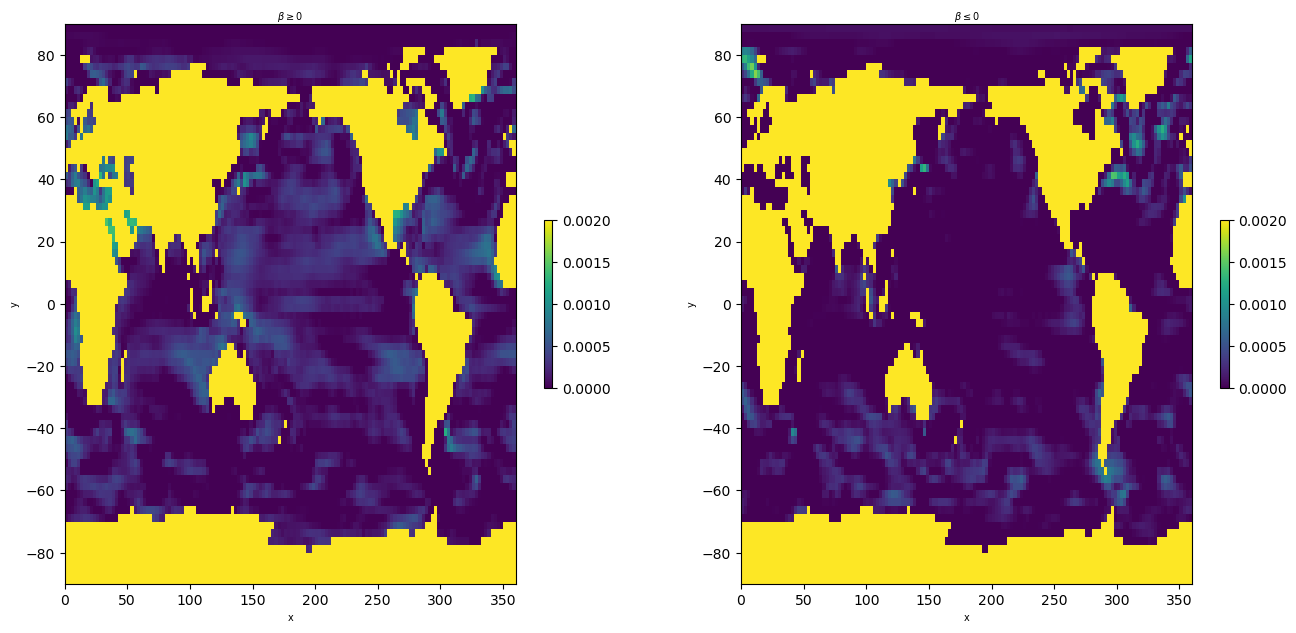

In [11]:
# define grid
longitude = np.load('longitude.npy')
latitude = np.load('latitude.npy')
lat_grid, lon_grid = np.meshgrid(latitude, longitude, indexing='ij')

# define beta to plot
beta_softmax = beta.detach().clone()
beta_softmax[nans_idx] = 1e5
beta_softmax = beta_softmax.detach().numpy().reshape(grid_lat_size,grid_lon_size)

# define positive part
beta_tmp = torch.max(beta.detach().clone(),torch.tensor(0.0))
beta_tmp[nans_idx] = 1e5
beta_softmax_pos = beta_tmp.detach().numpy().reshape(grid_lat_size,grid_lon_size)

# compute negative part
beta_softmax_neg = torch.min(beta.detach().clone(),torch.tensor(0.0))
beta_softmax_neg[nans_idx] = 1e5
beta_softmax_neg = beta_softmax_neg.detach().numpy().reshape(grid_lat_size,grid_lon_size)

fig0 = plt.figure(figsize=(16,16))           

ax0 = fig0.add_subplot(2, 2, 1)        
ax0.set_title(r'$\beta \geq 0$', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,beta_softmax,vmin=-0.00,vmax = 0.002)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax0 = fig0.add_subplot(2, 2, 2)        
ax0.set_title(r'$\beta \leq 0$', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,np.abs(beta_softmax_neg),vmin=0.00,vmax = 0.002)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)


plt.show()

### Plot the coefficient map

In [12]:
# compute the coefficient using soft max
M = len(list(dic_reduced_ssp585.keys()))
gamma = torch.zeros(M)

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    gamma[idx_m] = torch.exp((1/alpha_)*torch.mean((y_train[m] - torch.matmul(x_train[m],beta))**2/variance_processed_ssp585[m]))

gamma = gamma/torch.sum(gamma)

/tmp/ipykernel_15294/1651779959.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=-90)


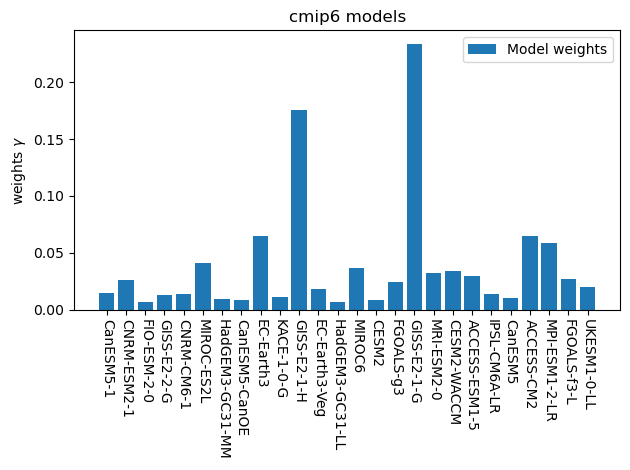

In [13]:
fig, ax = plt.subplots()

models = list(dic_reduced_ssp585.keys())

weights = list(gamma.detach().numpy())
# bar_labels = ['red', 'blue', '_red', 'orange']
# bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']

ax.bar(models, weights,label='Model weights')
ax.set_ylabel(r'weights $\gamma$')
ax.set_title('cmip6 models')
ax.legend()
ax.set_xticklabels(models, rotation=-90)
plt.tight_layout()
plt.show()

### plot the worst model and the best model with respect to the mean squared error on the training model

In [14]:
processed_models = list(dic_processed_ssp585.keys())
rmse = torch.zeros(len(processed_models))
for idx_m,m in enumerate(processed_models):
    print('Model : ', m)
    rmse[idx_m] = torch.mean((y_train[m] - torch.matmul(x_train[m][:,notnans_idx],beta[notnans_idx]))**2)
    print(rmse[idx_m].item())

Model :  CanESM5-1
0.0041777449660003185
Model :  CNRM-ESM2-1
0.002661362988874316
Model :  FIO-ESM-2-0
0.0019048601388931274
Model :  GISS-E2-2-G
0.0013357553398236632
Model :  CNRM-CM6-1
0.0025494068395346403
Model :  MIROC-ES2L
0.002409855369478464
Model :  HadGEM3-GC31-MM
0.0028998139314353466
Model :  CanESM5-CanOE
0.003966824617236853
Model :  EC-Earth3
0.004945645574480295
Model :  KACE-1-0-G
0.002582524437457323
Model :  GISS-E2-1-H
0.006180694326758385
Model :  EC-Earth3-Veg
0.0035037819761782885
Model :  HadGEM3-GC31-LL
0.0027934431564062834
Model :  MIROC6
0.0020784803200513124
Model :  CESM2
0.0021381087135523558
Model :  FGOALS-g3
0.0012964368797838688
Model :  GISS-E2-1-G
0.007072796579450369
Model :  MRI-ESM2-0
0.0022468804381787777
Model :  CESM2-WACCM
0.0033774003386497498
Model :  ACCESS-ESM1-5
0.0025428771041333675
Model :  IPSL-CM6A-LR
0.003584054298698902
Model :  CanESM5
0.004333138931542635
Model :  ACCESS-CM2
0.004457182250916958
Model :  MPI-ESM1-2-LR
0.0021552

### Compute the ridge regression estimator

In [15]:
# regularizer coefficient 
lambda_ = 1.0

# set number of iterations
nbEpochs = 1000

# display logs
verboseBool =True

beta = torch.zeros(grid_lat_size*grid_lon_size).to(torch.float64)
beta.requires_grad_(True)  
          
# define optimizer
optimizer = torch.optim.SGD([beta],lr=1e-3)

# number of models
M = len(list(dic_reduced_ssp585.keys()))
        
# --- optimization loop ---                
for epoch in torch.arange(nbEpochs):      
                  
    optimizer.zero_grad()
    ############### Define loss function ##############
                
    # first term: ||Y - X - Rb ||
    obj = torch.tensor(0.0)
    for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
        obj += (0.5/M)*torch.nanmean((y_train[m] - torch.matmul(x_train[m],beta))**2)

    # add some regularization term 
    # obj += lambda_*torch.norm(beta,p=2)**2
                
    #define loss function
    loss = obj
                
    # Use autograd to compute the backward pass. 
    loss.backward(retain_graph=True)               
    
    # take a step into optimal direction of parameters minimizing loss
    optimizer.step()       
                
    # clamp the variables
    # with torch.no_grad():
        # beta[:] = torch.clamp(beta[:],min=0.0)
    
    if(verboseBool==True):
        if(epoch % 10 == 0):
            print('Epoch ', epoch.detach().item(), 
                ', loss=', loss.detach().item()
                )

Epoch  0 , loss= 0.012363550253212452
Epoch  10 , loss= 0.002674457849934697
Epoch  20 , loss= 0.0023067763540893793
Epoch  30 , loss= 0.0021121404133737087
Epoch  40 , loss= 0.0019872330594807863
Epoch  50 , loss= 0.0018974730046465993
Epoch  60 , loss= 0.0018284288235008717
Epoch  70 , loss= 0.0017731088446453214
Epoch  80 , loss= 0.0017275870777666569
Epoch  90 , loss= 0.001689382130280137
Epoch  100 , loss= 0.00165679887868464
Epoch  110 , loss= 0.0016286208992823958
Epoch  120 , loss= 0.0016039490001276135
Epoch  130 , loss= 0.0015821048291400075
Epoch  140 , loss= 0.0015625681262463331
Epoch  150 , loss= 0.0015449365600943565
Epoch  160 , loss= 0.0015288942959159613
Epoch  170 , loss= 0.0015141908079385757
Epoch  180 , loss= 0.001500627025961876
Epoch  190 , loss= 0.0014880411326885223
Epoch  200 , loss= 0.0014763018116354942
Epoch  210 , loss= 0.0014653016114607453
Epoch  220 , loss= 0.001454950775951147
Epoch  230 , loss= 0.0014451759634539485
Epoch  240 , loss= 0.0014359137276

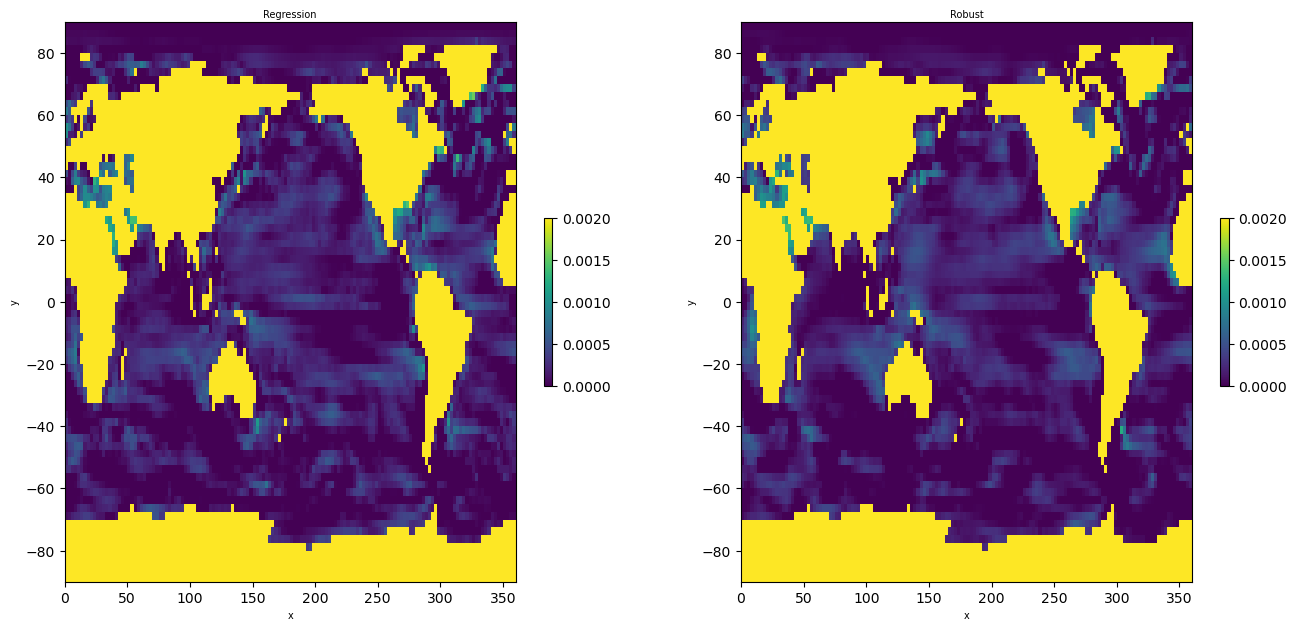

In [16]:
# define grid
longitude = np.load('longitude.npy')
latitude = np.load('latitude.npy')
lat_grid, lon_grid = np.meshgrid(latitude, longitude, indexing='ij')

# define beta to plot
beta_tmp = beta.detach().clone()
beta_tmp[nans_idx] = 1e5
beta_reg = beta_tmp.detach().numpy().reshape(grid_lat_size,grid_lon_size)

beta_softmax[beta_softmax< -1e3] = 1e5

fig0 = plt.figure(figsize=(16,16))           

ax0 = fig0.add_subplot(2, 2, 1)        
ax0.set_title('Regression', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,beta_reg,vmin=-0.00,vmax = 0.002)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax1 = fig0.add_subplot(2, 2, 2)        
ax1.set_title('Robust', size=7,pad=3.0)
im1 = ax1.pcolormesh(lon_grid,lat_grid,beta_softmax,vmin=-0.00,vmax = 0.002)
plt.colorbar(im1, ax=ax1, shrink=0.3)
ax1.set_xlabel(r'x', size=7)
ax1.set_ylabel(r'y', size=7)


plt.show()

# remove the worst model and see what we get

In [17]:
worst_model = 'GISS-E2-1-G'

# softmax coefficient
alpha_ = 1.0

# regularizer coefficient 
lambda_ = 1.0

# set number of iterations
nbEpochs = 1000

# display logs
verboseBool =True

beta = torch.zeros(grid_lat_size*grid_lon_size).to(torch.float64)
beta.requires_grad_(True)  
          
           
# define optimizer
optimizer = torch.optim.SGD([beta],lr=1e-3)
        
# --- optimization loop ---                
for epoch in torch.arange(nbEpochs):      
                  
    optimizer.zero_grad()
    ############### Define loss function ##############
                
    # first term: ||Y - X - Rb ||
    obj = torch.tensor(0.0)
    for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
        if m != worst_model:
            obj += torch.exp((1/alpha_)*torch.nanmean((y_train[m] - torch.matmul(x_train[m],beta))**2))

    obj = alpha_*torch.log(obj)

    # add some regularization term 
    # obj += lambda_*torch.norm(beta,p=2)**2
                
    #define loss function
    loss = obj
                
    # Use autograd to compute the backward pass. 
    loss.backward(retain_graph=True)               
    
    # take a step into optimal direction of parameters minimizing loss
    optimizer.step()       
                
    # clamp the variables
    # with torch.no_grad():
        # beta[:] = torch.clamp(beta[:],min=0.0)
    
    if(verboseBool==True):
        if(epoch % 10 == 0):
            print('Epoch ', epoch.detach().item(), 
                ', loss=', loss.detach().item()
                )

Epoch  0 , loss= 3.2440836429595947
Epoch  10 , loss= 3.2228736877441406
Epoch  20 , loss= 3.222308874130249
Epoch  30 , loss= 3.222052812576294
Epoch  40 , loss= 3.221895456314087
Epoch  50 , loss= 3.2217867374420166
Epoch  60 , loss= 3.2217061519622803
Epoch  70 , loss= 3.2216436862945557
Epoch  80 , loss= 3.2215921878814697
Epoch  90 , loss= 3.2215492725372314
Epoch  100 , loss= 3.2215118408203125
Epoch  110 , loss= 3.2214789390563965
Epoch  120 , loss= 3.221449613571167
Epoch  130 , loss= 3.2214226722717285
Epoch  140 , loss= 3.221398115158081
Epoch  150 , loss= 3.2213752269744873
Epoch  160 , loss= 3.221353769302368
Epoch  170 , loss= 3.2213339805603027
Epoch  180 , loss= 3.2213149070739746
Epoch  190 , loss= 3.221297264099121
Epoch  200 , loss= 3.221280574798584
Epoch  210 , loss= 3.221264362335205
Epoch  220 , loss= 3.2212488651275635
Epoch  230 , loss= 3.221234083175659
Epoch  240 , loss= 3.2212202548980713
Epoch  250 , loss= 3.2212066650390625
Epoch  260 , loss= 3.221193552017

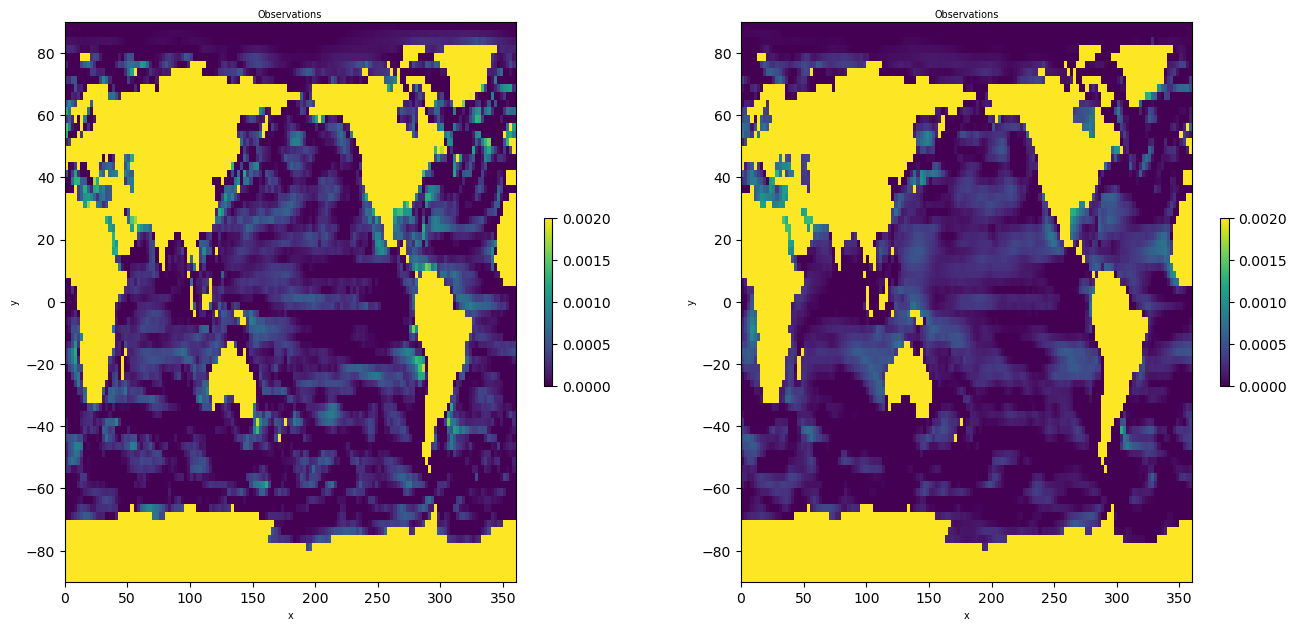

In [18]:
# define grid
longitude = np.load('longitude.npy')
latitude = np.load('latitude.npy')
lat_grid, lon_grid = np.meshgrid(latitude, longitude, indexing='ij')

# define beta to plot
beta_tmp = beta.detach().clone()
beta_tmp[nans_idx] = 1e5
beta_reg = beta_tmp.detach().numpy().reshape(grid_lat_size,grid_lon_size)

beta_softmax[beta_softmax<-1e3] = 1e5

fig0 = plt.figure(figsize=(16,16))           

ax0 = fig0.add_subplot(2, 2, 1)        
ax0.set_title('Observations', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,beta_reg,vmin=-0.00,vmax = 0.002)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax1 = fig0.add_subplot(2, 2, 2)        
ax1.set_title('Observations', size=7,pad=3.0)
im1 = ax1.pcolormesh(lon_grid,lat_grid,beta_softmax,vmin=-0.00,vmax = 0.002)
plt.colorbar(im1, ax=ax1, shrink=0.3)
ax1.set_xlabel(r'x', size=7)
ax1.set_ylabel(r'y', size=7)


plt.show()